In [1]:
model_name = 'nassm/convnext_nano' # Pre-trained model name
batch_size=32
num_workers=64

In [2]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
def normalize(array):
    """
    Normalize values between 0 and 1 using min-max scaling
    
    Args:
        array: pandas Series containing values to normalize
    
    Returns:
        tuple: (pandas Series with normalized values between 0 and 1 as float32, fitted scaler)
    """
    scaler = MinMaxScaler()
    normalized = scaler.fit_transform(array.values.reshape(-1, 1))
    return pd.Series(normalized.flatten(), index=array.index, name='norm', dtype='float32'), scaler

In [3]:
#---------------------#
path = '/home/nasserm/local/zoobot/examples/finetuning/tmp/metadata/'
label='Vm' # km/s
id_str = 'plateifu'
#---------------------#

train_ = pd.read_csv('rot/train_dataset.csv')
test_ = pd.read_csv('rot/test_dataset.csv')

train_['file_loc'] = path + train_['file_loc'].astype(str)
train_['id_str'] = train_[id_str]
test_['file_loc'] = path + test_['file_loc'].astype(str)
test_['id_str'] = test_[id_str]


In [4]:
# Normalize label column
import numpy as np
train_[label] = normalize(np.abs(train_[label]))[0]
test_[label] = normalize(np.abs(test_[label]))[0]

In [5]:
from galaxy_datasets.pytorch.galaxy_datamodule import CatalogDataModule
from galaxy_datasets.transforms import default_view_config, get_galaxy_transform
batch_size=32
num_workers=64


transform_cfg = default_view_config()
transform = get_galaxy_transform(transform_cfg)


datamodule = CatalogDataModule(
    label_cols = [label],
    catalog = train_,
    train_transform = transform,
    test_transform = transform,
    batch_size= batch_size,
    num_workers= num_workers
    )

GZDESI/GZRings/GZCD not available from galaxy_datasets.pytorch.datasets - skipping


In [6]:
datamodule.label_cols

['Vm']

In [7]:
from zoobot.pytorch.training.finetune import FinetuneableZoobotRegressor
model = FinetuneableZoobotRegressor(
    label_col=label,
    name='nassm/convnext_nano',
    learning_rate=1e-6,  
    unit_interval=True
)

In [8]:
from zoobot.pytorch.training.finetune import get_trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
save_dir = '/home/nasserm/local/zoobot/examples/finetuning/tmp/metadata/training'

csv_logger = CSVLogger(
    save_dir=save_dir,
    name='training_logs',
    version=None
)
trainer = get_trainer(
    save_dir,
    accelerator='auto',
    devices='auto',
    max_epochs=5,
    logger=csv_logger,
    enable_checkpointing=True
        )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [9]:
trainer.fit(model, datamodule)

/home/nasserm/local/miniconda3/envs/mangazoo/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | encoder           | ConvNeXt         | 15.0 M | train
1 | train_loss_metric | MeanMetric       | 0      | train
2 | val_loss_metric   | MeanMetric       | 0      | train
3 | test_loss_metric  | MeanMetric       | 0      | train
4 | head              | LinearHead       | 641    | train
5 | train_rmse        | MeanSquaredError | 0      | train
6 | val_rmse          | MeanSquaredError | 0      | train
7 | test_rmse         | MeanSquaredError | 0      | train
---------------------------------------------------------------
15.0 M    Trainable params
0         Non-trainable 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'finetuning/val_loss' reached 0.03205 (best 0.03205), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/0.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'finetuning/val_loss' reached 0.02985 (best 0.02985), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'finetuning/val_loss' reached 0.02703 (best 0.02703), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'finetuning/val_loss' reached 0.02428 (best 0.02428), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/3.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'finetuning/val_loss' reached 0.02283 (best 0.02283), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/4-v3.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [10]:
from zoobot.pytorch.predictions import predict_on_catalog
best_checkpoint = trainer.checkpoint_callback.best_model_path
# best_checkpoint = ckpt = '/home/nasserm/local/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/4.ckpt'
finetuned_model = FinetuneableZoobotRegressor.load_from_checkpoint(best_checkpoint)

In [11]:
predictions_path='/home/nasserm/local/zoobot/examples/finetuning/tmp/metadata/training/preds/save.csv'
predictions_result =predict_on_catalog.predict(
                    catalog=test_,
                    model=finetuned_model,
                    inference_transform=transform,
                    label_cols=['label'],  # Pass as list instead of string
                    save_loc=predictions_path,
                    trainer_kwargs={'accelerator': 'auto', 'devices': 'auto'},
                    datamodule_kwargs={'num_workers': 2, 'batch_size': 32},
                    )

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

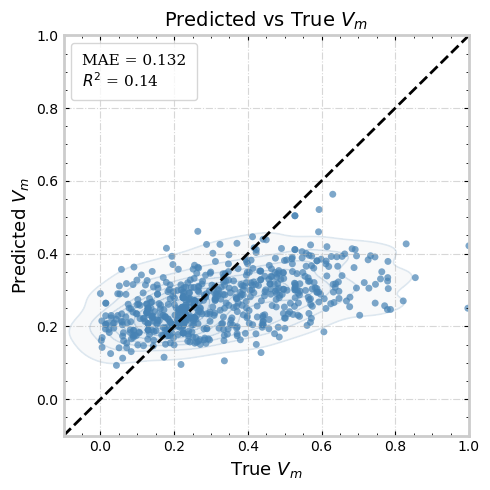

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
from matplotlib.lines import Line2D

def plot_form(ax):
    ax.grid(ls='-.', alpha=0.5, zorder=0)
    ax.tick_params(direction='in')
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_linewidth(2)
        ax.spines[spine].set_color('0.8')
    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    ax.minorticks_on()
    plt.rcParams['font.family'] = 'serif'

# Merge predictions with true values using id_str
merged = test_.merge(predictions_result, on='id_str')

# helper: metrics legend
def add_metrics_legend(ax, y_true, y_pred):
    def sigfig(x, n=2):
        if x == 0:
            return "0"
        return f"{x:.{n}g}"
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    text = f"MAE = {sigfig(mae, 3)}\n$R^2$ = {sigfig(r2, 2)}"
    handle = Line2D([], [], marker='o', color='w', alpha=0, linestyle='None')
    ax.legend([handle], [text], loc='upper left', fontsize=11, frameon=True,
              borderpad=0.7, labelspacing=0.3, handlelength=0, handletextpad=0)

# helper: contours
def plot_contours(ax, x, y):
    cmap = sns.light_palette('steelblue', as_cmap=True)
    if len(x) > 10:
        try:
            sns.kdeplot(x=x, y=y, ax=ax, fill=True, cmap=cmap,
                        levels=8, thresh=0.05, alpha=0.25, zorder=0)
            sns.kdeplot(x=x, y=y, ax=ax, color='steelblue',
                        levels=8, thresh=0.05, linewidths=1.2,
                        fill=False, alpha=0.15, zorder=1)
        except Exception:
            pass

# plot
fig, ax = plt.subplots(figsize=(5, 5))
plot_form(ax) 

x = merged['Vm']       # true
y = merged['label']    # predicted

plot_contours(ax, x, y)
sns.scatterplot(x=x, y=y, ax=ax, alpha=0.7, s=25, color='steelblue', edgecolor='none')

# 1:1 reference line
ax.plot([x.min()-0.1, x.max()], [x.min()-0.1, x.max()],
        color='black', linestyle='--', linewidth=2)

# labels and title
ax.set_xlabel('True $V_m$', fontsize=13)
ax.set_ylabel('Predicted $V_m$', fontsize=13)
ax.set_title('Predicted vs True $V_m$', fontsize=14)
ax.set_xlim(-0.1, 1)
ax.set_ylim(-0.1, 1)

# add metrics legend
add_metrics_legend(ax, x, y)

plt.tight_layout()
plt.show()